## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

## Exploring the data

In [2]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('../neuralnets/aclImdb/train')
test_ds = text_dataset_from_directory('../neuralnets/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 25001 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


/home/jaidevd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [4]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
4966,"Humm, an Italian movie starred by David hasselhoff and Linda Blair, I wasn´t expecting very much, to be honest and in fact, I took even less than I was expecting. It doesn´t mean this movie is the...",0
24885,"Not only was this movie better than all the final season of H:LOTS. But it was better than any movie made for TV I have ever seen!<br /><br />Looking at the ""Top 250"" I see that only one small scr...",1
2310,"This is a well-worn story about a man who marries to escape the hangman's noose, then sets about ""taming"" his reluctant bride. It manages to be sexist and racist at exactly the same time. We never...",0
13648,"Being from a small town in Illinois myself, I can instantly relate to this movie. Considering the era it was made in, the townsfolk look uncomfortably like a lot of people I grew up with. Yes the ...",1
4021,"(David H. Steinberg)'s script seemed initially having some real smart points that could've made good romantic comedy, BUT BUT BUT, oh dear ! What did ever happen in the way ???!!!! <br /><br />I'l...",0


In [5]:
print(dfTrain.loc[0, 'text'])

I'm sure this was one of those "WOAH!" attractions in 1982 when Epcot opened, but now it's just silly. The film's message is cliché. The Circle-Vision is disorienting. And that awful song at the end is grating. And I really wish they'd install seats. After so much walking, all you want to do is sit down for a few minutes. And when you hear there's a film to see it sounds pretty glamorous! You get entertained while sitting down, right? WRONG! You're standing there for 18+ minutes leaning against a short little railing. Disney should make a newer Maelstrom like attraction to liven things up and replace this dull, lackluster film. NOT FUN. Skip it. In fact, skip Canada altogether unless you're eating there. Move directly to the United Kingdom.


## Tokenize the text

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [7]:
print(train_sequences[0])

[143, 249, 11, 13, 28, 4, 145, 21906, 14896, 8, 6436, 51, 52009, 3050, 18, 147, 42, 40, 705, 1, 593, 746, 6, 1588, 1, 4201, 1768, 6, 21907, 2, 12, 370, 610, 30, 1, 127, 6, 8169, 2, 10, 63, 654, 3396, 23379, 7180, 100, 35, 73, 1282, 29, 22, 178, 5, 78, 6, 866, 177, 15, 3, 168, 231, 2, 51, 22, 839, 222, 3, 19, 5, 64, 9, 931, 181, 5794, 22, 76, 2162, 134, 1260, 177, 205, 352, 332, 2086, 47, 15, 3051, 231, 12258, 426, 3, 343, 114, 20600, 906, 141, 94, 3, 5926, 27631, 37, 3210, 5, 13420, 180, 53, 2, 5171, 11, 750, 5120, 19, 21, 250, 1769, 9, 8, 189, 1769, 3462, 3899, 891, 332, 1883, 47, 844, 2547, 5, 1, 2345, 4517]


In [8]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

["i'm", 'sure', 'this', 'was', 'one', 'of', 'those', 'woah', 'attractions', 'in', '1982', 'when', 'epcot', 'opened', 'but', 'now', "it's", 'just', 'silly', 'the', "film's", 'message', 'is', 'cliché', 'the', 'circle', 'vision', 'is', 'disorienting', 'and', 'that', 'awful', 'song', 'at', 'the', 'end', 'is', 'grating', 'and', 'i', 'really', 'wish', "they'd", 'install', 'seats', 'after', 'so', 'much', 'walking', 'all', 'you', 'want', 'to', 'do', 'is', 'sit', 'down', 'for', 'a', 'few', 'minutes', 'and', 'when', 'you', 'hear', "there's", 'a', 'film', 'to', 'see', 'it', 'sounds', 'pretty', 'glamorous', 'you', 'get', 'entertained', 'while', 'sitting', 'down', 'right', 'wrong', "you're", 'standing', 'there', 'for', '18', 'minutes', 'leaning', 'against', 'a', 'short', 'little', 'railing', 'disney', 'should', 'make', 'a', 'newer', 'maelstrom', 'like', 'attraction', 'to', 'liven', 'things', 'up', 'and', 'replace', 'this', 'dull', 'lackluster', 'film', 'not', 'fun', 'skip', 'it', 'in', 'fact', 'ski

In [9]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [10]:
MAX_SEQUENCE_LENGTH

2493

In [11]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [14]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [15]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30
391/391 [==============================] - 8s 21ms/step - loss: 0.5434 - accuracy: 0.7303 - val_loss: 0.5326 - val_accuracy: 0.7371
Epoch 2/30
391/391 [==============================] - 8s 21ms/step - loss: 0.5192 - accuracy: 0.7445 - val_loss: 0.5388 - val_accuracy: 0.7354
Epoch 3/30
391/391 [==============================] - 8s 21ms/step - loss: 0.5096 - accuracy: 0.7485 - val_loss: 0.5097 - val_accuracy: 0.7507
Epoch 4/30
391/391 [==============================] - 8s 21ms/step - loss: 0.5011 - accuracy: 0.7566 - val_loss: 0.5057 - val_accuracy: 0.7552
Epoch 5/30
391/391 [==============================] - 8s 21ms/step - loss: 0.4975 - accuracy: 0.7540 - val_loss: 0.5047 - val_accuracy: 0.7536
Epoch 6/30
391/391 [==============================] - 8s 21ms/step - loss: 0.4956 - accuracy: 0.7577 - val_loss: 0.5032 - val_accuracy: 0.7525
Epoch 7/30
391/391 [==============================] - 8s 21ms/step - loss: 0.4910 - accuracy: 0.7595 - val_loss: 0.5073 - val_accuracy: 0.7576

# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [29]:
glove_wiki = KeyedVectors.load_word2vec_format('data/glove.6B.300d.txt', binary=False, no_header=True)

In [34]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [35]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=30
)

Epoch 1/30
782/782 [==============================] - 19s 25ms/step - loss: 0.5488 - accuracy: 0.7243 - val_loss: 0.4494 - val_accuracy: 0.8083
Epoch 2/30
782/782 [==============================] - 20s 25ms/step - loss: 0.4324 - accuracy: 0.8130 - val_loss: 0.4147 - val_accuracy: 0.8235
Epoch 3/30
782/782 [==============================] - 19s 25ms/step - loss: 0.4065 - accuracy: 0.8247 - val_loss: 0.4126 - val_accuracy: 0.8154
Epoch 4/30
782/782 [==============================] - 19s 25ms/step - loss: 0.3940 - accuracy: 0.8269 - val_loss: 0.3854 - val_accuracy: 0.8341
Epoch 5/30
782/782 [==============================] - 19s 25ms/step - loss: 0.3845 - accuracy: 0.8326 - val_loss: 0.3799 - val_accuracy: 0.8360
Epoch 6/30
782/782 [==============================] - 19s 25ms/step - loss: 0.3821 - accuracy: 0.8306 - val_loss: 0.3760 - val_accuracy: 0.8363
Epoch 7/30
782/782 [==============================] - 19s 24ms/step - loss: 0.3777 - accuracy: 0.8344 - val_loss: 0.3989 - val_accuracy:

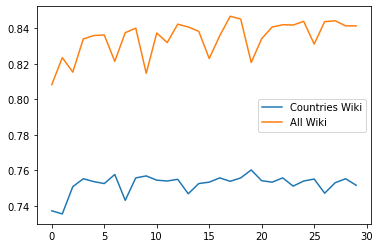

In [36]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()